In [ ]:
from GRID_2D import * 
from METROPOLIS import *

import jax.numpy as jnp
import numpy as np # Often needed for defining the initial grid ranges
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as plt
import jax.numpy as jnp
import seaborn as snb
snb.set_style('darkgrid')
snb.set(font_scale=1.5)
plt.rcParams['lines.linewidth'] = 3
#jupyter nbconvert test_exam_2024.ipynb --to webpdf


## Part 5: Markov Chain Monte Carlo

Assume the posterior density for a model with parameters $z_1, z_2 \in \mathbb{R}$ and data $\mathcal{D}$ are given by

$$
\log p(z_1, z_2 \mid \mathcal{D}) = -(1 - z_1)^2 - 20(z_2 - z_1^2)^2 - z_1^2 - z_2^2 + \text{constant}
\tag{9}
$$



### Question 5.1

Plot the contours of the posterior density for the ranges $z_1 \in [-2, 2] \quad \text{and} \quad z_2 \in [-1, 3]$ with 100 equidistant points for both $z_1$ and $z_2$.

Let $
z = \begin{bmatrix} z_1 & z_2 \end{bmatrix}$ and consider a Metropolis sampler with an isotropic Gaussian proposal distribution  
$$
q(z^* \mid z^{(k-1)}) = \mathcal{N}(z^* \mid z^{(k-1)}, I)
$$   for  $z^{(k)} = \begin{bmatrix} z_1^{(k)} & z_2^{(k)} \end{bmatrix},$  
where $k \in \mathbb{N}$ denotes the iteration number.


Maximum posterior at alpha = 0.44 and beta = 0.17171717


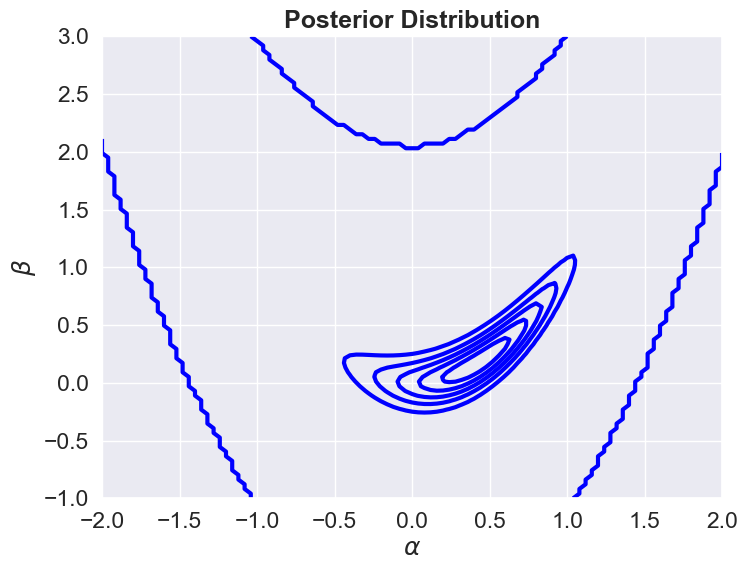

In [ ]:
# Define the log-posterior function as given in the question:
# log p(z_1, z_2 | D) = -(1 - z_1)^2 - 20(z_2 - z_1^2)^2 - z_1^2 - z_2^2 + const
# Input: z1 (scalar or array), z2 (scalar or array)
# Output: log-posterior value(s), shape matches broadcasting of z1 and z2
log_joint = lambda z1, z2 : - 1 * (1 - z1)**2 - 20 * (z2 - z1**2) ** 2 - z1**2 - z2**2 

# Create 101 points for z1 in [-2, 2] and 100 points for z2 in [-1, 3]
# z1_s: shape (101,), z2_s: shape (100,)
z1_s = jnp.linspace(-2, 2, 101)
z2_s = jnp.linspace(-1, 3, 100)

# Instantiate a 2D grid for evaluating the posterior over the parameter space
# Grid2D expects: (z1_s, z2_s, log_joint, name)
# grid.log_density has shape (len(z2_s), len(z1_s))
grid = Grid2D(z1_s, z2_s, log_joint, name="Posterior Distribution")

# Create a matplotlib figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot contours of the posterior density (exp(log_joint)) on the grid
# The function f=jnp.exp converts log-density to density
# num_contours=5 draws 5 contour lines
grid.plot_contours(ax, color='blue', num_contours=5, f=jnp.exp, title="Posterior Distribution")

# Find the (z1, z2) pair with the maximum posterior value on the grid
# grid.argmax returns (max_alpha, max_beta)
max_alpha, max_beta = grid.argmax
print("Maximum posterior at alpha =", max_alpha, "and beta =", max_beta)

plt.show()

### Question 5.2

Run a single MCMC chain using the Metropolis algorithm for $10^4$ iterations using the proposal distribution given above.  
Initialize the chain at $(z_1, z_2) = (0, 1.5)$. Discard 10% of the samples as warm up. Plot the resulting traces for both parameters.


Acceptance ratio: 0.09
Lengh of the warmup period = 1000


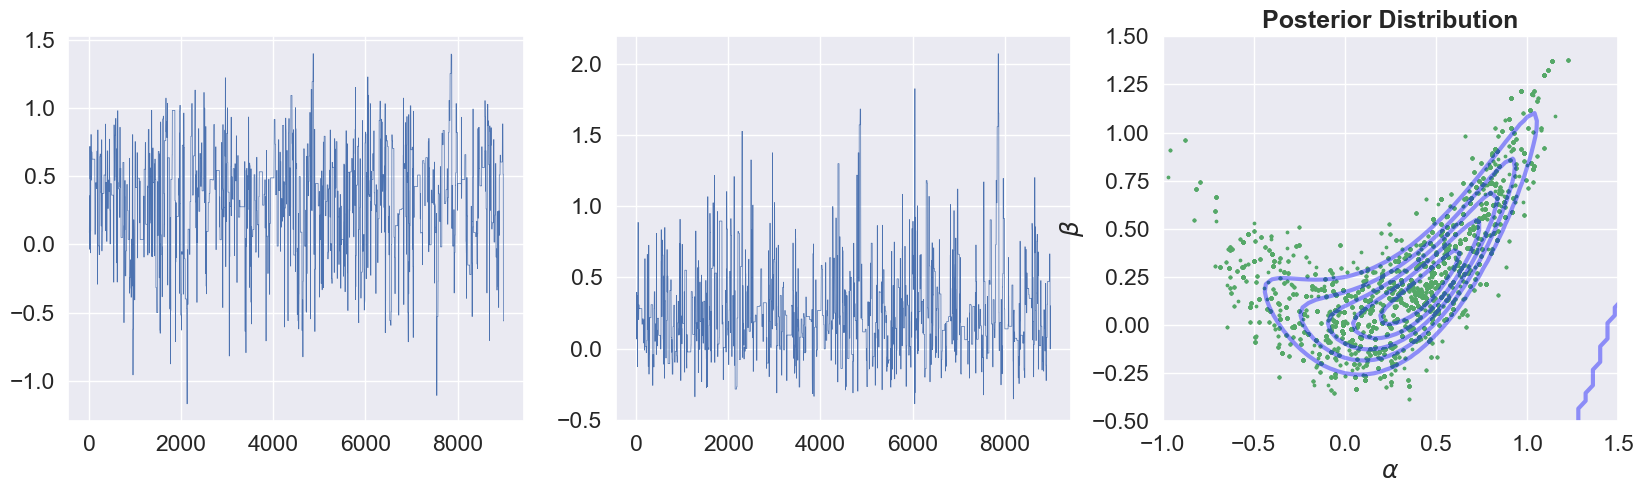

In [27]:
log_joint_vec = lambda theta: log_joint(theta[0], theta[1]) # This is because the metropolis expects the input to be a vector of parameters

NUM_ITTER = 10**4
NUM_PARAMS = 2
THETA_INIT = jnp.array([0, 1.5])
TAU = 1

# Run the Metropolis MCMC sampler
# Inputs:
#   log_target: function that takes a parameter vector theta (shape: (2,)) and returns log-posterior (scalar)
#   num_params: number of parameters (int, here 2)
#   tau: proposal stddev (float, here 1)
#   num_iter: number of MCMC iterations (int, here 10000)
#   theta_init: initial parameter vector (shape: (2,))
# Output:
#   thetas: array of sampled parameter vectors (shape: (num_iter, 2))
# Equation for proposal: q(z^* | z) = N(z^* | z, I)
thetas = metropolis(
    log_target=log_joint_vec,  # log-posterior function, input: theta (shape (2,)), output: scalar
    num_params=NUM_PARAMS,     # number of parameters (2)
    tau=TAU,                   # proposal stddev
    num_iter=NUM_ITTER,         # number of MCMC iterations
    theta_init=THETA_INIT,      # initial parameter vector (shape (2,))
    seed=1
)

warmup = int(0.1 * NUM_ITTER)
print(f"Lengh of the warmup period = {warmup}")


thetas = thetas[warmup:]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(thetas[:, 0], lw=0.5)

axes[1].plot(thetas[:, 1], lw=0.5)
axes[2].scatter(thetas[:, 0], thetas[:, 1], color='g', s=3)
axes[2].set_xlim(-1,1.5)
axes[2].set_ylim(-0.5,1.5)
grid.plot_contours(axes[2], color='blue', num_contours=5, f=jnp.exp, title="Posterior Distribution", alpha=.4)
plt.show()

Use the posterior samples of $z$ from Question 5.2 to answer the next two questions. 


### Question 5.3:
Estimate the posterior mean of $\sin(z_1 z_2)$ using the samples.

The following can be approximated with the Monte Carlo, 

$$\mathbb{E}[\sin(z_1 z_2) | \mathcal{D}] \approx \frac{1}{S} \sum_{i=1}^S \sin(z_1^{(i)} z_2^{(i)}) \approx 0.13$$



In [29]:
post_mean_sinus = jnp.mean(jnp.sin(thetas[:, 0] * thetas[:, 1]))

print(f"The posterior mean of sin(z1 * z2) = {post_mean_sinus:.2f}")

The posterior mean of sin(z1 * z2) = 0.14


### Question 5.4:
Estimate the posterior probability $p(z_1 > z_2 \mid \mathcal{D})$ using the samples.

This can be approximated with the monte carlo sampling, 

$$p(z_1 > z_2 | \mathcal{D}) \approx \frac{1}{S} \sum_{i=1}^S \mathbb{I}[z_1^{(i)} > z_2^{(i)}] \approx 0.68$$


In [30]:
z1 = thetas[:, 0]
z2 = thetas[:, 1]

post = z1[z1 > z2]


print(f"Posterior probability p(z1 > z2) = {len(post) / len(z1) * 100:.2f} % ")

Posterior probability p(z1 > z2) = 71.28 % 


____

If you did not solve the previous question, you can draw $10^4$ samples of $z$ as

$$
z \sim \mathcal{N} \left(
\begin{bmatrix}
1 \\
2
\end{bmatrix},
\begin{bmatrix}
1 & 0.3 \\
0.3 & 1
\end{bmatrix}
\right)
\tag{10}
$$

and assume these are samples from the correct posterior distribution when solving the next two questions.

In [39]:
import jax

mean = jnp.array([1.0, 2.0])
cov = jnp.array([
    [1, 0.3],
    [0.3, 1]
                ])

key = jax.random.PRNGKey(1)

L = jnp.linalg.cholesky(cov)

z = jax.random.normal(key, shape=(NUM_ITTER, 2))

samples_cholesky = mean + z @ L.T
mean_sin = jnp.mean(jnp.sin(samples_cholesky[: , 0] * samples_cholesky[:, 1]))
print(f"E(sin(z1 * z2) | D) = {mean_sin:3.2f}")

E(sin(z1 * z2) | D) = 0.15


In [42]:
# Use JAX's random.normal and Cholesky decomposition to sample from the multivariate normal
z_normal = jax.random.normal(key, shape=(NUM_ITTER, 2))
z_nomal = mean + z_normal @ L.T
mean_sin_library = jnp.mean(jnp.sin(z_nomal[:, 0] * z_nomal[:, 1]))
print(f"E(sin(z1 * z2) | D) = {mean_sin_library:3.2f}")

E(sin(z1 * z2) | D) = 0.15


In [44]:
z1_ch = samples_cholesky[:, 0] 
z2_ch = samples_cholesky[:, 1]

post_prob_ch = np.mean(z1_ch > z2_ch)

print(f"p[z1 > z2 | D] = {post_prob_ch:.2f}")

p[z1 > z2 | D] = 0.20
